# Bayesian Network Analysis and Power Estimation in R
    
## Introduction

### Bayesian networks (BNs) provide a probabilistic framework to model relationships among variables. This notebook covers:
    
    - Bayesian network structure learning
    - Computing effect sizes (Cramér's V and Mutual Information)
    - Assessing the Markov Blanket's predictive power
    - Investigating sample size requirements when adding a node
    - Evaluating logistic regression and Cohen's f^2 for Bayesian network performance
    - Understanding and interpreting key statistical results
    - Visualizing the relationship between effect size and sample size when adding a node
    

In [1]:

    # Load necessary libraries
    library(bnlearn)
    library(DescTools)
    library(infotheo)
    library(pwr)
    library(car)
    

Warning message:
“package ‘DescTools’ was built under R version 4.3.3”
Warning message:
“package ‘infotheo’ was built under R version 4.3.3”

Attaching package: ‘infotheo’


The following object is masked from ‘package:bnlearn’:

    discretize


Warning message:
“package ‘car’ was built under R version 4.3.3”
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:DescTools’:

    Recode




## As an example we ware going to use the Asia dataset

### The Asia dataset is a small, synthetic dataset often used in Bayesian network modeling to illustrate probabilistic dependencies between variables. It consists of 8 binary variables that represent a simple medical diagnostic scenario.

### The dataset models the probability of a patient having lung disease based on smoking history and exposure to tuberculosis. The 8 variables are:

## Asia Dataset: Variable Descriptions

The **Asia dataset** is a small **Bayesian network dataset** used for modeling medical diagnosis.

| **Variable** | **Values** | **Description** |
|-------------|-----------|----------------|
| **A (Asia)** | 1 = Yes, 2 = No | Has the patient recently visited Asia? (Tuberculosis risk factor) |
| **T (Tuberculosis)** | 1 = Yes, 2 = No | Does the patient have tuberculosis? |
| **S (Smoking)** | 1 = Yes, 2 = No | Is the patient a smoker? |
| **L (Lung Cancer)** | 1 = Yes, 2 = No | Does the patient have lung cancer? |
| **B (Bronchitis)** | 1 = Yes, 2 = No | Does the patient have bronchitis? |
| **E (Either Tuberculosis or Lung Cancer)** | 1 = Yes, 2 = No | Does the patient have either tuberculosis or lung cancer? |
| **X (X-ray Result)** | 1 = Abnormal, 2 = Normal | Is the X-ray result abnormal? |
| **D (Dyspnea - Shortness of Breath)** | 1 = Yes, 2 = No | Does the patient have dyspnea? |



## Bayesian Network Structure
The **Bayesian network structure** models the probabilistic dependencies between variables:

- **A → T** (Visiting Asia increases tuberculosis risk)
- **S → L** (Smoking increases lung cancer risk)
- **S → B** (Smoking increases bronchitis risk)
- **T, L → E** (Either tuberculosis or lung cancer can lead to a positive diagnosis)
- **E → X** (If the patient has either disease, the X-ray is likely abnormal)
- **B, E → D** (Bronchitis or a major disease can cause shortness of breath)

### How This Dataset is Used:
- **Probabilistic Inference**: Compute disease probabilities given symptoms.
- **Bayesian Network Learning**: Train Bayesian models for diagnosis.
- **Sensitivity Analysis**: Identify the most influential factors.

---


In [2]:

    # Load example dataset
    data("asia")

    # Convert to factors (bnlearn assumes categorical/discrete data)
    asia <- as.data.frame(lapply(asia, as.factor))
    

## Define Bayesian Network Structure and Fit Model

In [3]:

    # Define Bayesian network structure
    dag <- model2network("[A][T|A][S][L|S][B|S][E|T:L][X|E][D|B:E]")

    # Learn conditional probability tables (CPTs)
    fitted_bn <- bn.fit(dag, data = asia, method = "bayes")
    

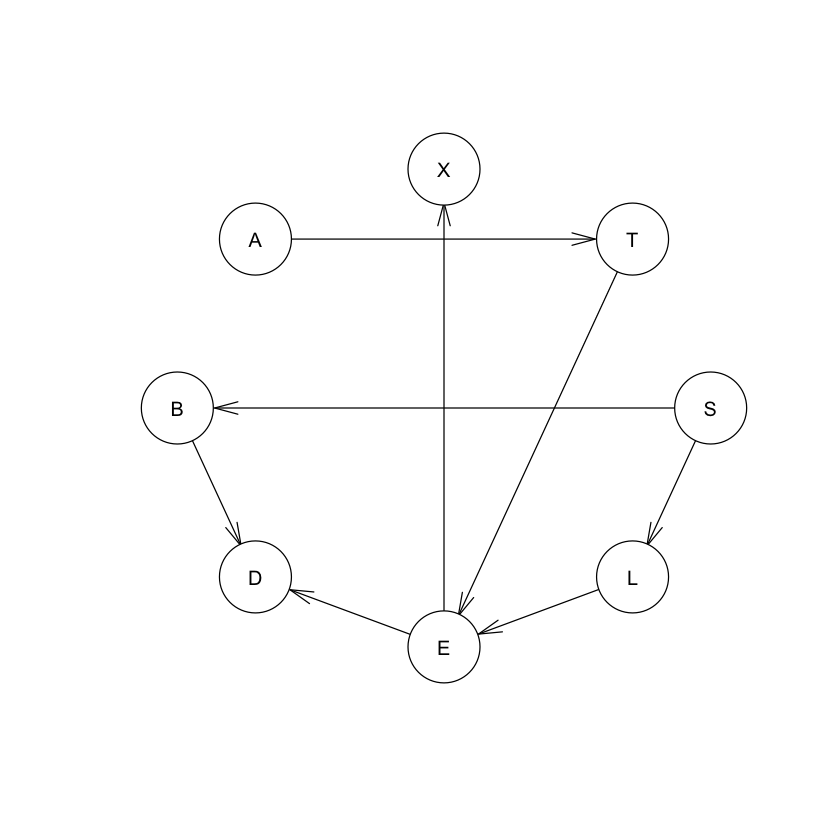

In [4]:

    # Visualize the Bayesian Network
    plot(dag)
    

### to assess the strength of associations within the network we can calcule the effect size between each node and a target outcome in our discrete Bayesian network (BN) 

### We will examine three methods:

### 1. Calculate effect size between Individual Nodes and the outcome

- **Cramér's V** for categorical nodes
- **Mutual Information (MI)** as a generalizable measure of association

## 2. Combined Effect Size for the Markov Blanket

- **Multivariate Mutual Information**
- **Cohen’s $ f^2 $ from a Logistic Regression**

## 3. Add a new Node and calculate sample size require to maintain effect size

### **Summary**
| **Metric** | **Purpose** | **Scale** |
|------------|------------|-----------|
| **Cramér's V** | Measures association for categorical variables | 0 (no association) to 1 (strongest) |
| **Mutual Information (MI)** | Measures how much knowing $X$ helps predict $Y$ | Non-negative values (higher is better) |
| **Normalized MI (NMI)** | MI adjusted for entropy | 0 to 1 |
| **Cohen’s $ f^2 $** | Measures how much variance is explained | Small (0.02), Medium (0.15), Large (0.35) |

---

## 1. Effect Size Between Individual Nodes and the Outcome

For each node $X_i$ and the target outcome $Y$, we can calculate effect sizes using:

- **Cramér's V** for categorical nodes
- **Mutual Information (MI)** as a generalizable measure of association

### **Cramér’s V for Categorical Data**
$$
V = \sqrt{\frac{\chi^2}{N \times (k - 1)}}
$$
where:
- $\chi^2$ is the chi-square statistic from a contingency table between $X_i$ and $Y$
- $N$ is the total number of observations
- $k$ is the smaller of the number of categories in $X_i$ and $Y$

👉 **Interpretation:**  
- **0**: No association  
- **1**: Strongest association  

---

In [20]:

    compute_cramer_v <- function(data, target) {
      effect_sizes <- sapply(names(data), function(var) {
        if (var != target) {
          tbl <- table(data[[var]], data[[target]])
          return(CramerV(tbl))
        } else {
          return(NA)
        }
      })
      return(effect_sizes)
    }

    cramer_v_results <- compute_cramer_v(asia, "L")
    print(cramer_v_results)
    

          A           S           T           L           B           E 
0.010838647 0.209459065 0.009453076          NA 0.065689525 0.940347043 
          X           D    MB_joint 
0.736737856 0.180604186 0.994231864 



    **Interpreting Cramér's V:**
    - 0.1-0.3: Weak relationship
    - 0.3-0.5: Moderate relationship
    - > 0.5: Strong relationship
    

### **Mutual Information (MI)**
$$
MI(X_i, Y) = \sum_{x,y} P(x, y) \log \frac{P(x, y)}{P(x)P(y)}
$$
- Measures the **information gain** of knowing $X_i$ for predicting $Y$.
- A **higher MI** means $X_i$ is more informative about $Y$.
- Can be **normalized** to a range of 0 to 1 using:
  
  $$
  NMI(X, Y) = \frac{MI(X, Y)}{\sqrt{H(X) H(Y)}}
  $$
  where $H(X)$ and $H(Y)$ are the **entropies** of $X$ and $Y$.

👉 **Why Mutual Information?**
- Unlike Cramér’s V, it is **not limited by sample size**.
- Works for **both categorical and discrete numeric variables**.

---

In [6]:

    # Compute Mutual Information Between Each Node and Target Outcome
    mi_results <- sapply(names(asia), function(var) {
      if (var != "L") {
        return(mutinformation(asia[, var], asia[, "L"]))
      } else {
        return(NA)
      }
    })
    print(mi_results)
    

           A            S            T            L            B            E 
5.215910e-05 2.499115e-02 4.030709e-05           NA 2.185351e-03 2.178190e-01 
           X            D 
1.621412e-01 1.721902e-02 



    **Interpreting MI:**
    - < 0.1: Weak association
    - 0.1-0.3: Moderate association
    - > 0.3: Strong association
    

## 2. Combined Effect Size for the Markov Blanket

The **Markov blanket** of the outcome $Y$ consists of:
- **Parents** of $Y$ (direct causes)
- **Children** of $Y$ (direct effects)
- **Co-parents** (other nodes influencing $Y$'s children)

👉 **Why Compute a Combined Effect Size?**
- The **Markov blanket contains all variables** that provide **direct information** about the target.
- If the effect size of the **Markov blanket is high**, then **no additional variables** outside the Markov blanket contribute significantly to predicting $Y$.

---

### **Ways to Compute the Combined Effect Size**
#### **1. Multivariate Mutual Information**
Calculate **joint mutual information** between the Markov blanket variables $MB(Y)$ and $Y$:

$$
MI(MB(Y), Y)
$$

- This captures **how much total information** the Markov blanket contains about $Y$.

In [8]:
# Get Markov blanket of the outcome variable
mb_lung <- mb(fitted_bn, "L")
print(mb_lung)

[1] "E" "S" "T"


In [9]:
# Compute Mutual Information (MI) for each node in the Markov Blanket with respect to L
joint_mi <- sum(sapply(mb_lung, function(var) mutinformation(asia[, var], asia[, "L"])))

print(paste("Joint Mutual Information for Markov Blanket:", round(joint_mi, 4)))


[1] "Joint Mutual Information for Markov Blanket: 0.2429"


#### **2. Cohen’s $ f^2 $ from a Logistic Regression**
- Fit a **logistic regression** model predicting $Y$ using its **Markov blanket variables**.
- Compute $ R^2 $ from the model and convert it to **Cohen’s $ f^2 $**:

$$
f^2 = \frac{R^2}{1 - R^2}
$$

In [22]:
##Logistic regression and Cohen's f2
# Convert factors to numeric for regression
asia_num <- as.data.frame(lapply(asia, function(x) as.numeric(as.factor(x))))

# Fit logistic regression using Markov Blanket variables
formula <- as.formula(paste("L ~", paste(mb_lung, collapse = " + ")))
logit_model <- glm(formula, data = asia_num-1, family = binomial)

# Compute R-squared
r2 <- 1 - (logLik(logit_model)[1] / logLik(glm(L ~ 1, data = asia_num-1, family = binomial))[1])

# Compute Cohen’s f^2
f2 <- r2 / (1 - r2)

print(paste("Cohen's f2 for Markov Blanket: ", round(f2, 3)))


[1] "Cohen's f2 for Markov Blanket:  93.76"


👉 **Interpretation of $ f^2 $:**
- **Small**: $ f^2 = 0.02 $  
- **Medium**: $ f^2 = 0.15 $  
- **Large**: $ f^2 = 0.35 $  

✅ **If $ f^2 $ is large**, the **Markov blanket explains most of the variation** in $Y$.  
❌ **If $ f^2 $ is small**, **additional dependencies** outside the Markov blanket may be influencing $Y$.

---

#### F2 = 93.76 suffests overfitting or data leakage
#### Solution: Investigate high R2, check VIF, and validate the dataset.

2. What Does $ f^2 =93.76$ Mean?

- **This suggests that $ R^2 $ is extremely close to 1 (likely > 0.99).**
- **The Markov Blanket predictors explain almost all of the variance in the outcome variable.**
- **In most real-world scenarios, effect sizes this high are suspiciously large and may indicate:**

    - **Data leakage (some predictors are directly derived from the outcome).**
    - **Overfitting (e.g., too many predictors relative to the number of observations).**
    - **Collinearity issues (predictors are highly correlated).**
    - **A deterministic relationship (not common in real-world noisy data).**

### Diagnosing the issueL

Check $R^2$ value

In [23]:
summary(logit_model)$deviance  # Model deviance
summary(logit_model)$null.deviance  # Null deviance
r2 <- 1 - (summary(logit_model)$deviance / summary(logit_model)$null.deviance)
print(paste("R-squared:", round(r2, 4)))


[1] 25.66144

[1] 2431.671

[1] "R-squared: 0.9894"


If $R^2$ ≈ 1 it confirms near-perfect prediction.

Check for Perfect Predictions

In [24]:
table(asia_num$L, predict(logit_model, type = "response") > 0.5)


   
    FALSE TRUE
  1  4670    0
  2     4  326

If one of the groups (0 or 1) is always predicted correctly, your model is too good, possibly due to a data issue.

##### Check Multicollinearity

In [25]:
library(car)
vif(logit_model)


E        S        T 
15.38734  1.00000 15.38734

if VIF > 10, predictors are highly collinear, which can inflate $f^2$

✔ Check the Markov Blanket: Ensure predictors are not artificially linked to the outcome.<br />
✔ Reduce Collinearity: Remove highly correlated predictors based on VIF > 10.<br />
✔ Increase Sample Size: If you have very few observations relative to predictors, the model may overfit.

## Compute True Joint MI Using Discretization

### If you want true joint MI, you can discretize the entire Markov Blanket as a joint variable:

In [26]:
#2. Compute True Joint MI Using Discretization
#If you want true joint MI, you can discretize the entire Markov Blanket as a joint variable:
 
# Create a joint variable by concatenating the Markov Blanket nodes
asia$MB_joint <- apply(asia[, mb_lung], 1, paste, collapse = "-")

# Compute MI between the joint variable and the outcome
joint_mi <- mutinformation(asia$MB_joint, asia$L)

print(paste("True Joint Mutual Information for Markov Blanket:", round(joint_mi, 4)))

[1] "True Joint Mutual Information for Markov Blanket: 0.2406"



### A Mutual Information (MI) score of 0.2406 between the Markov Blanket and the outcome (L)  means that the Markov Blanket variables collectively contain moderate information about the outcome. 

### MI = 0.2406 suggests that 24.06% of the uncertainty in L (the outcome) is explained by the Markov Blanket variables.

## This is moderate information gain—not extremely strong, but still useful.

In [27]:
##Normalize the MI to a 0-1 scale
library(infotheo)
H_L <- entropy(asia$L)
H_MB <- entropy(asia$MB_joint)  # If using joint variable method
NMI <- joint_mi / sqrt(H_L * H_MB)
print(paste("Normalized MI:", round(NMI, 3)))

[1] "Normalized MI: 0.498"



## NMI ranges from 0 to 1, making it easier to interpret:

#### 0 → No relationship
#### 0.1 - 0.3 → Weak relationship
#### 0.3 - 0.5 → Moderate relationship
#### > 0.5 → Strong relationship

### If MI is low (~0.05-0.1):
##### The Markov Blanket does not provide much useful information about the outcome. Consider adding more relevant predictors.

### If MI is moderate (~0.2-0.4) (like your case):The Markov Blanket is somewhat predictive of L.
##### Further refinement or additional features may improve performance.

### If MI is high (>0.5):The Markov Blanket contains substantial predictive information.
##### Model performance should be strong.

# Let's add a new node

In [29]:
library(pwr)

# Existing effect size
r2_old <- 0.24  # Example from previous MI calculation
f2_old <- r2_old / (1 - r2_old)  # Cohen’s f^2

num_predictors_old <- length(mb_lung)
# Original sample size calculation
sample_size_old <- pwr.f2.test(u = num_predictors_old, 
                               v = NULL,  # Will be calculated
                               f2 = f2_old, 
                               sig.level = 0.05, 
                               power = 0.8)

n = sample_size_old$u+sample_size_old$v+1
print(paste("Estimated Sample size current model",n))

[1] "Estimated Sample size current model 38.6644636877459"


## Compute Sample Size Before and After Adding a Node

In [13]:

    find_sample_size <- function(r2, num_predictors, power = 0.8, alpha = 0.05) {
      f2 <- r2 / (1 - r2)
      result <- pwr.f2.test(u = num_predictors, v = NULL, f2 = f2, sig.level = alpha, power = power)
      N <- ceiling(result$v + num_predictors + 1)
      return(N)
    }

    # Compute required sample size before and after adding a node
    r2_old <- 0.24
    r2_new <- 0.12
    num_predictors_old <- length(mb_lung)
    num_predictors_new <- num_predictors_old + 1

    sample_size_old <- find_sample_size(r2_old, num_predictors_old)
    sample_size_new <- find_sample_size(r2_new, num_predictors_new)

    print(paste("Sample size before adding a node:", sample_size_old))
    print(paste("Sample size after adding a node:", sample_size_new))
    

[1] "Sample size before adding a node: 39"
[1] "Sample size after adding a node: 93"


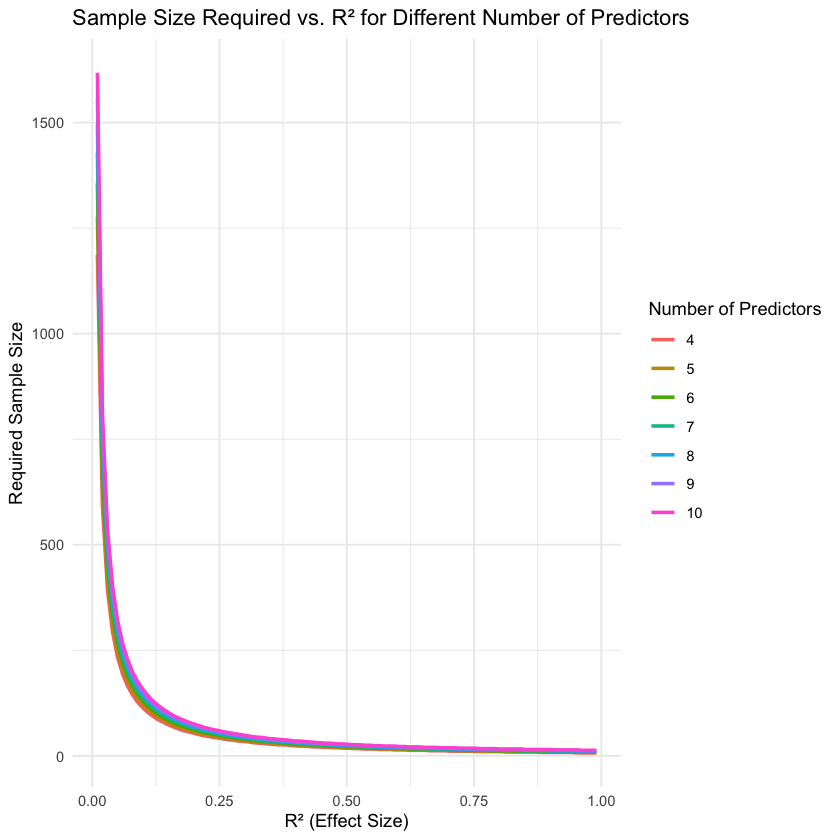

In [18]:
# Load required libraries
library(ggplot2)
library(pwr)


# Define range of R² values
r2_values <- seq(0.01, 0.99, length.out = 100)  # 100 values between 0.01 and 0.99
num_predictors_list <- 4:10  # Model complexity: 5 to 10 predictors

# Create an empty dataframe
data <- data.frame()

# Compute sample sizes for each R² value and number of predictors
for (num_predictors in num_predictors_list) {
  sample_sizes <- sapply(r2_values, function(r2) find_sample_size(r2, num_predictors))
  temp_data <- data.frame(R2 = r2_values, SampleSize = sample_sizes, Predictors = as.factor(num_predictors))
  data <- rbind(data, temp_data)
}

# Plot the results with multiple lines for different predictor counts
ggplot(data, aes(x = R2, y = (SampleSize), color = Predictors)) +
  geom_line(linewidth = 1) +  # Updated for ggplot2 v3.4+
  labs(
    title = "Sample Size Required vs. R² for Different Number of Predictors",
    x = "R² (Effect Size)",
    y = "Required Sample Size",
    color = "Number of Predictors"
  ) +
  theme_minimal()

